# Training ResNet-XGBoost Classifier

This notebook presents a full pipeline to train and evaluate a model that distinguishes between AI-generated and human-created images. <br> <br>
It leverages deep visual features extracted from a **pretrained ResNet model**, followed by dimensionality reduction using **PCA** and classification using **XGBoost**.

#### Import libraries

In [ ]:
%load_ext autoreload
%autoreload 2

from src.utils.model_utils import save_model
import yaml
from src.data.human_ai_dataset import HumanVSAIDataset
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from tqdm import tqdm
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load configuration

In [3]:
%load_ext autoreload
%autoreload 2

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')
print("Loaded configuration")
# print(yaml.dump(config, default_flow_style=False))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded configuration


#### Data loading and preprocessing

In [4]:
def extract_labels(dataset, batch_size=64, num_workers=8):
    """
    Extracts labels from a dataset using a DataLoader for parallel processing.
    """
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    labels = []

    for _, y in tqdm(loader, desc="Extracting labels", total=len(loader)):
        # y is a tensor batch
        labels.append(y.numpy() if not y.is_cuda else y.cpu().numpy())

    return np.concatenate(labels, axis=0)

In [ ]:
labels_map = {
    0: 'Human generated',
    1: 'AI generated'
}

# Transforming the images 

transform = transforms.Compose([
    # Random crop and resize the image to 128x128
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(30),  # Random rotation within a range of -30 to +30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color adjustments
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image to [-1, 1]
])

# transform = Compose([
#     Resize((128, 128)),
#     # ToTensor(),
#     Normalize(mean=[0.5, 0.5, 0.5],
#                         std=[0.5, 0.5, 0.5])
# ])

dataset = HumanVSAIDataset(
    annotations_file_path=config['dataset']['train_csv'],
    transform=transform
)

trainset_size = 1 - config['dataset']['test_split']
trainset_size = int(len(dataset) * trainset_size)
valset_size = int(len(dataset) - trainset_size)

trainset, valset = torch.utils.data.random_split(dataset, [trainset_size, valset_size])
y_train = extract_labels(trainset)
y_val = extract_labels(valset)

print(f"Total trainset size: {len(dataset)}")
print(f"Training dataset size: {len(trainset)}")
print(f"Validation dataset size: {len(valset)}")

Extracting labels: 100%|██████████| 375/375 [01:14<00:00,  5.01it/s]

Total trainset size: 79950
Training dataset size: 55965
Validation dataset size: 23985


#### Visualize some transformed images

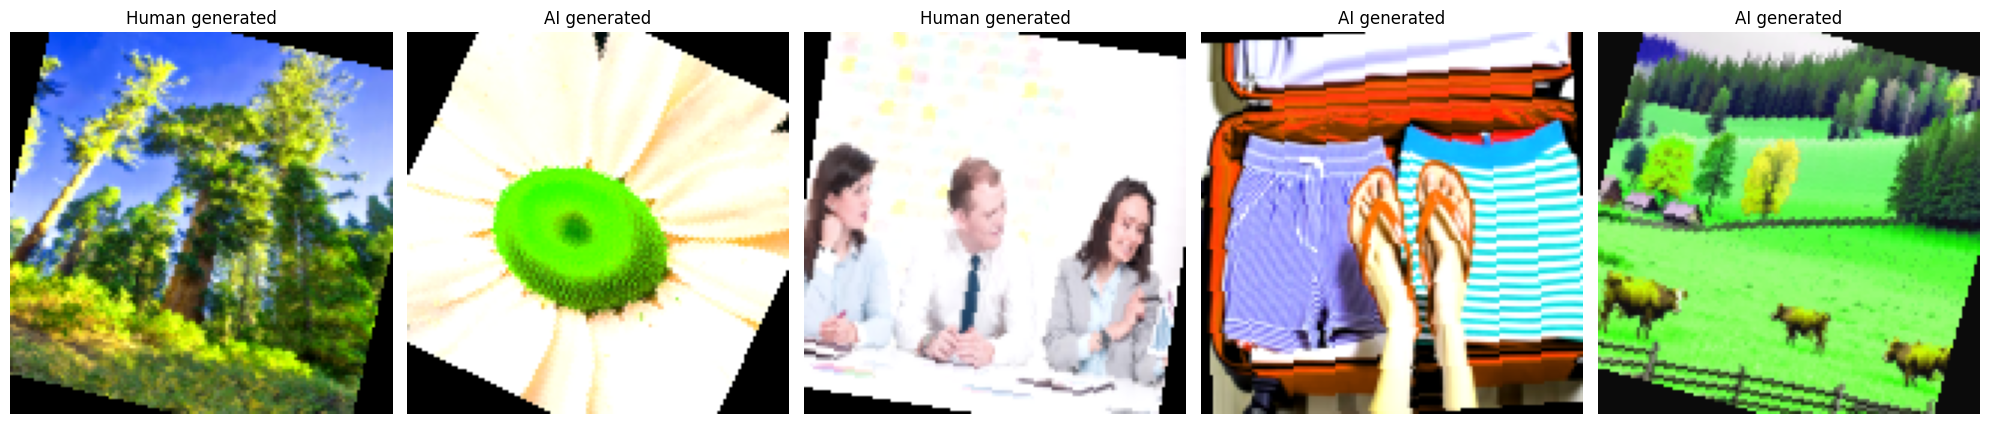

In [6]:
def show_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img, label = dataset[i]


        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy() 

        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].set_title(labels_map[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(trainset)

### Building the architecture

#### FeatureExtraction using ResNET

In [7]:
class TorchResNetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, batch_size=32, device=None):
        self.batch_size = batch_size
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._build_model().to(self.device).eval()

    def _build_model(self):
        """Builds the ResNet model, removing the final fully connected layer."""
        resnet = models.resnet18(pretrained=True)  # You can choose a different ResNet model if needed
        return nn.Sequential(*list(resnet.children())[:-1])  # Remove the final FC layer

    def fit(self, X, y=None):
        """Fit method for scikit-learn compatibility (though we're not using this)."""
        return self

    def transform(self, dataset):
        """Transforms the dataset by extracting features from the ResNet model."""
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        all_features = []
        
        for images, _ in tqdm(loader, desc="Extracting Features"):
            images = images.to(self.device)  # Move images to the device (GPU or CPU)
            with torch.no_grad():
                features = self.model(images)  # Extract features
                features = features.view(features.size(0), -1)  # Flatten the features
                all_features.append(features.cpu().numpy())  # Move back to CPU and convert to numpy
        
        return np.concatenate(all_features, axis=0)  # Return the extracted features as a numpy array

In [8]:
def plot_singular_values(X):
    """Plot singular values of the feature matrix."""
    pca = PCA(n_components=X.shape[1])  # Compute PCA for full space to get singular values
    pca.fit(X)
    
    # Plot singular values (Scree plot)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(pca.singular_values_) + 1), pca.singular_values_, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Singular Values')
    plt.title('Singular Values vs Components')
    plt.grid(True)
    plt.show()

#### Extract features from the images and use PCA to reduce dimensions

Extracting Features: 100%|██████████| 1749/1749 [13:26<00:00,  2.17it/s]


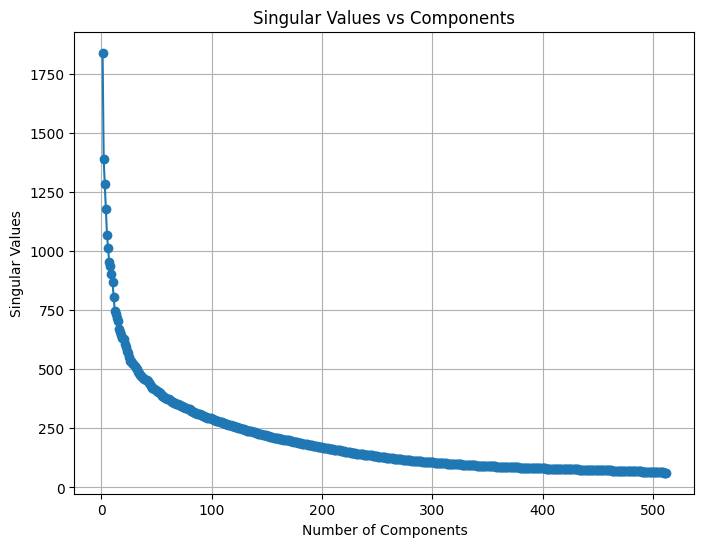

In [10]:
feature_extractor = TorchResNetTransformer(batch_size=32)
features = feature_extractor.transform(trainset)
plot_singular_values(features)

We can see that singular values VS number of components plot, 100 seems to be the point that forms the elbow, therefore, selecting `n_components=100`.

#### Training pipeline

In [11]:
n_components = 100  # Based on elbow method or singular value plot

pipeline = Pipeline([
    ("pca", PCA(n_components=n_components)),
    ("classifier", xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])


#### Fit/Train the `XGBClassifier`

In [ ]:
pipeline.fit(features, y_train)

[*] Training pipeline...


/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:16:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('pca', PCA(n_components=100)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

#### Evaluating on validation set

In [ ]:
val_features = feature_extractor.transform(valset)
y_pred = pipeline.predict(val_features)

[*] Evaluating...


Extracting Features: 100%|██████████| 750/750 [04:41<00:00,  2.67it/s]


In [19]:
acc = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Validation Accuracy : {acc:.4f}")
print(f"Precision           : {precision:.4f}")
print(f"Recall              : {recall:.4f}")
print(f"F1 Score            : {f1:.4f}")

Validation Accuracy : 0.7915
Precision           : 0.7859
Recall              : 0.7991
F1 Score            : 0.7924
